# Clustering
## Transformation

Transforming features that are heavily skewed can help clustering algorithms (like k-means) treat them more fairly. So we'll do that first.

**Speechiness and Instrumentalness**: These features are heavily skewed towards low values. Since clustering algorithms like k-means assume roughly spherical clusters (normally distributed features), applying a logarithmic or square root transformation can help normalize the distribution.

**Liveness** is also skewed towards lower values, so we'll do a log transformation here to spread out the lower values more evenly.

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import numpy as np


df = pd.read_csv('processed_data.csv')
df = df.drop(columns='loudness') ## drop loudness because it is highly correlated with energy

df['speechiness_log'] = np.log1p(df['speechiness'])  # log(1 + x) to handle zeros
df['instrumentalness_log'] = np.log1p(df['instrumentalness'])
df['liveness_log'] = np.log1p(df['liveness'])


clustering_features = ['danceability', 'energy', 'valence', 'tempo', 
                       'acousticness', 'speechiness_log', 'instrumentalness_log', 'liveness_log']

X = df[clustering_features]

## Number of clusters

Before applying k-means, it’s important to decide on the number of clusters (k). We'll use the Elbow Method to help determine an appropriate value of k.

c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

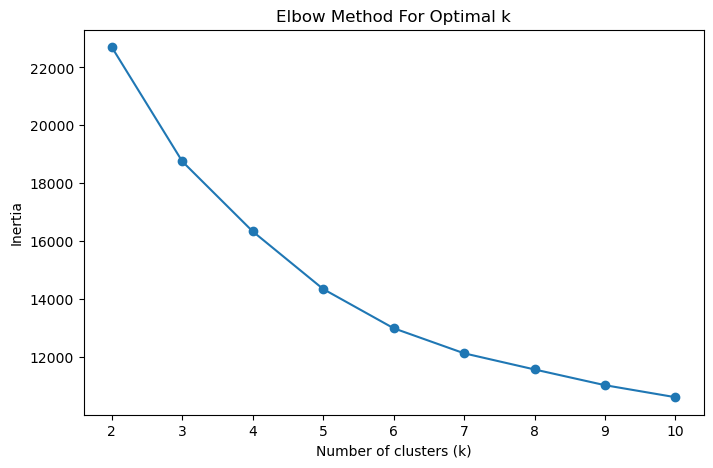

In [57]:
# Elbow method to determine optimal number of clusters
inertia = []
Krange = range(2, 14)  # Trying between 2 and 14 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot inertia to find the elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(K_range)
plt.show()



## K-Means Clustering

c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

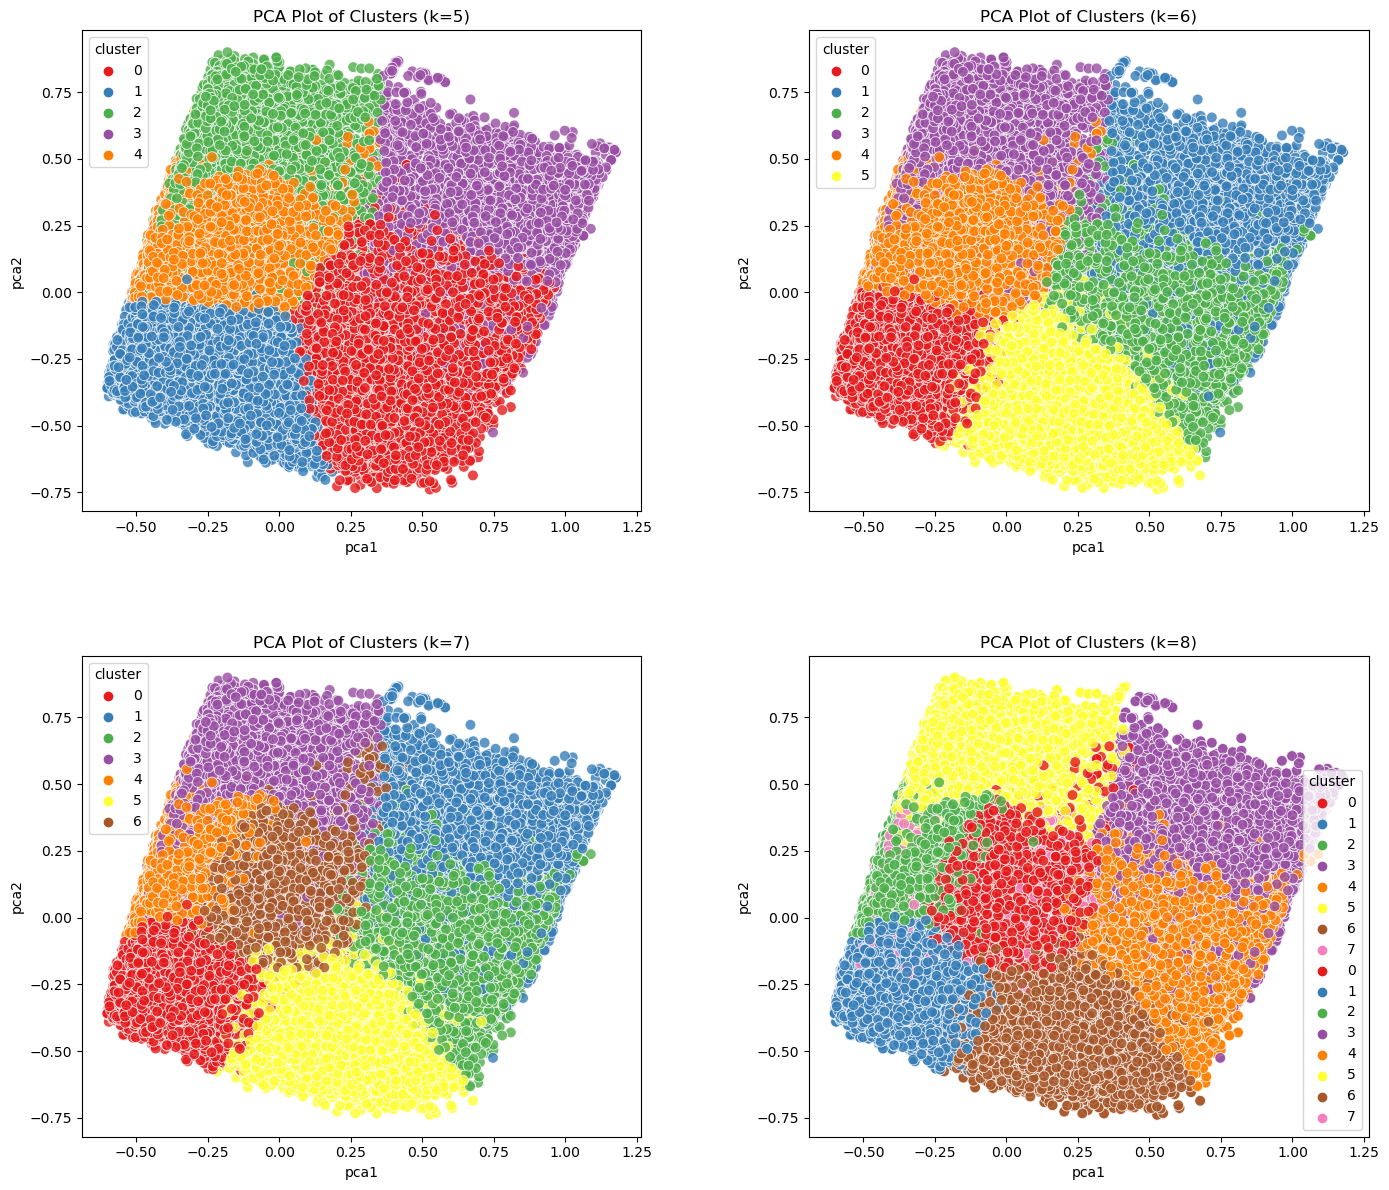

In [73]:
from sklearn.decomposition import PCA

# Apply k-means (k = 5,6,7,8. These values seems reasonable to try since is no distinct elbow)
kmeans = KMeans(n_clusters=7, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Reduce the dimensionality to 2D for visualization
plt.figure(figsize=(14, 12))
pca = PCA(n_components=2)
for i, k in enumerate([5, 6, 7, 8], start=1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)
    pca_components = pca.fit_transform(X)
    df['pca1'], df['pca2'] = pca_components[:, 0], pca_components[:, 1]
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set1', s=60, alpha=0.8)
    plt.title(f'PCA Plot of Clusters (k={k})')

#Plots showing how different k-means make clusters
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set1', s=60, alpha=0.8)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()



In [59]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for each
for k in [5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print(f'Silhouette Score for k={k}: {silhouette_avg}')


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=5: 0.24004700369075518


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=6: 0.22928633209092933


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=7: 0.2210766931536136


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=8: 0.22275914027549576


Each color represents a distinct cluster found by the k-means algorithm. Based on the Silhouette Score we will select k=5 because it is has the best value by a bit.
The fact that the clusters form relatively distinct shapes in the PCA plot means that k-means has been successful at separating the data points into groups based on the features. Overlaps or boundary areas might indicate songs that are somewhat similar in their audio features, leading to ambiguity in their clustering.

## Cluster Means
The first table provides the mean values for each feature within each cluster. These averages tell us about the general characteristics of each cluster based on the audio features:

In [75]:
kmeans = KMeans(n_clusters=7, random_state=42)
df['cluster'] = kmeans.fit_predict(X)  # Assign cluster labels to the DataFrame

# Get the mean values of features for each cluster
cluster_means = df.groupby('cluster')[clustering_features].mean()
print(cluster_means)


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


         danceability    energy   valence     tempo  acousticness  \
cluster                                                             
0            0.687093  0.777205  0.751926  0.513254      0.112755   
1            0.393092  0.203988  0.209760  0.433830      0.870905   
2            0.490528  0.322586  0.320459  0.465496      0.796894   
3            0.561948  0.768332  0.310230  0.523725      0.062423   
4            0.466956  0.877129  0.339377  0.552738      0.034667   
5            0.645609  0.609259  0.721058  0.493169      0.628962   
6            0.606720  0.561900  0.339529  0.483380      0.216906   

         speechiness_log  instrumentalness_log  liveness_log  
cluster                                                       
0               0.086917              0.026416      0.174112  
1               0.052809              0.610508      0.140994  
2               0.061208              0.015293      0.164179  
3               0.073168              0.572483      0.175076  


### Cluster 0:
High danceability (0.68), energy (0.77), and valence (0.73), meaning this cluster represents high-energy, upbeat, and danceable tracks.
Low acousticness (0.11), instrumentalness_log (0.02), and speechiness_log (0.09), suggesting that these are mainly non-acoustic, non-instrumental tracks with a focus on vocals.
### Cluster 1:
Low danceability (0.39), energy (0.20), and valence (0.21), representing slower, calmer, and more somber tracks.
Very high acousticness (0.87), meaning these are mostly acoustic tracks.
High instrumentalness_log (0.61), indicating a high proportion of instrumental tracks in this cluster.
### Cluster 2:
 Moderate danceability (0.50) and energy (0.33).
 High acousticness (0.76), suggesting this cluster contains more acoustic tracks.
Low valence (0.31), which implies a more somber or melancholic mood overall.
### Cluster 3:

Moderate danceability (0.56) and high energy (0.77), indicating energetic, moderately danceable tracks.
Low valence (0.31), suggesting these songs might be intense or dark.
Low acousticness (0.06) and high instrumentalness_log (0.57), meaning this cluster might represent high-energy instrumental tracks.
### Cluster 4:

Moderate danceability (0.51) and high energy (0.76), similar to cluster 3.
Low valence (0.31) and acousticness (0.08), which could represent high-energy, non-acoustic tracks, possibly in genres like electronic music.
### Cluster 5:

High danceability (0.65), energy (0.60), and valence (0.70), making it another cluster with generally upbeat, danceable tracks.
High acousticness (0.60), which is interesting given the higher energy and valence—this might indicate energetic acoustic tracks.   


## Lets look at the top 10 genres in the clusters

In [76]:
# Assuming you have a DataFrame 'df' with 'Cluster' and 'Genre' columns

# Calculate the distribution of genres in each cluster
genre_cluster_distribution = df.groupby('cluster')['track_genre'].value_counts().unstack(fill_value=0)

# Function to get top N genres for each cluster
def get_top_genres_per_cluster(cluster_distribution, top_n=10):
    top_genres = {}
    for cluster in cluster_distribution.index:
        # Sort genres by count within the cluster and get the top N
        top_genres[cluster] = cluster_distribution.loc[cluster].sort_values(ascending=False).head(top_n)
    return top_genres

# Get the top 10 genres for each cluster
top_genres = get_top_genres_per_cluster(genre_cluster_distribution, top_n=10)

# Print the top 10 genres for each cluster
for cluster, genres in top_genres.items():
    print(f"Cluster {cluster} - Top Genres:\n{genres}\n")


Cluster 0 - Top Genres:
track_genre
disco        596
party        594
kids         545
dancehall    529
dance        504
latin        490
ska          484
j-idol       450
afrobeat     440
forro        437
Name: 0, dtype: int64

Cluster 1 - Top Genres:
track_genre
new-age      751
ambient      684
sleep        614
classical    584
study        498
guitar       423
piano        419
disney       411
iranian      383
idm          293
Name: 1, dtype: int64

Cluster 2 - Top Genres:
track_genre
romance       667
opera         615
cantopop      504
show-tunes    501
acoustic      491
tango         488
honky-tonk    445
mandopop      356
indian        289
disney        287
Name: 2, dtype: int64

Cluster 3 - Top Genres:
track_genre
minimal-techno    744
detroit-techno    680
grindcore         609
chicago-house     481
black-metal       480
breakbeat         445
idm               444
trance            444
drum-and-bass     410
club              387
Name: 3, dtype: int64

Cluster 4 - Top Genres:




# Clustering Analysis of Music Genres

### Cluster Descriptions

- **Cluster 0**:  
  This cluster captures vibrant, dance-friendly genres, featuring **disco**, **party**, and **dancehall** alongside **kids** and **afrobeat**. It is upbeat and social, appealing to celebratory and youth-focused environments, with influences from **ska**, **j-idol**, and **forro**, making it lively and ideal for gatherings.

- **Cluster 1**:  
  A calm and relaxing cluster, including **new-age**, **ambient**, and **classical** genres. With instrumental genres like **guitar** and **piano** and the addition of **disney** and **sleep**, it provides a soothing or child-friendly atmosphere, suitable for unwinding, studying, or meditative activities.

- **Cluster 2**:  
  Romantic and acoustic-focused, this group brings together genres like **romance**, **opera**, and **show-tunes**. The presence of **Cantopop**, **Mandopop**, and **tango** hints at an international, theatrical feel, appealing to fans of traditional, emotional, and acoustic sounds.

- **Cluster 3**:  
  Known for its high-energy and intense sounds, this cluster includes **minimal-techno**, **grindcore**, and **drum-and-bass**. It leans toward electronic and fast-paced genres, attracting audiences in club or energetic settings, with subgenres like **breakbeat**, **trance**, and **black-metal** enhancing its intense appeal.

- **Cluster 4**:  
  This group is dominated by heavy and aggressive genres like **heavy-metal**, **metalcore**, and **death-metal**. With influences from **industrial**, **grunge**, and **dub**, it has an intense, gritty sound suitable for fans of rock and metal, adding a mix of heavy rhythms and raw energy.

- **Cluster 5**:  
  This cluster combines cheerful and genre-rich sounds such as **comedy**, **salsa**, and **forro**. Genres like **bluegrass**, **honky-tonk**, and **rock-n-roll** add a nostalgic or country flavor, while **children** and **pagode** make it suitable for light-hearted and family-friendly settings.

- **Cluster 6**:  
  A culturally diverse cluster, including genres like **turkish**, **mandopop**, and **world-music**. With **emo** and **hip-hop**, it spans emotional and rhythmic sounds, appealing to international and eclectic listeners, while also including **french** and **malay** genres for a global flair.

---

### Summary of Cluster Characteristics

- **Cluster 0**: Upbeat and social, with disco, party, and dance genres.
- **Cluster 1**: Calm and instrumental, including ambient, classical, and sleep.
- **Cluster 2**: Romantic and acoustic, featuring opera, romance, and show-tunes.
- **Cluster 3**: High-energy electronic, with techno, drum-and-bass, and grindcore.
- **Cluster 4**: Heavy and intense, with metal, grunge, and industrial.
- **Cluster 5**: Cheerful and nostalgic, including comedy, salsa, and rock-n-roll.
- **Cluster 6**: Diverse and international, with turkish, emo, and world music.



In [77]:
# Labelize the clusters with detailed descriptions
cluster_labels = {
    0: 'Upbeat Dance & Social Music - Featuring disco, party, kids, dancehall, and afrobeat genres for lively gatherings.',
    1: 'Calm & Relaxing Instrumentals - New-age, ambient, and classical genres for meditation, study, and relaxation.',
    2: 'Romantic & Acoustic Music - Genres like romance, opera, show-tunes, and tango for a theatrical and emotional feel.',
    3: 'High-energy Electronic & Intense Music - Minimal-techno, grindcore, and drum-and-bass for fast-paced settings.',
    4: 'Heavy Metal & Aggressive Rock - Intense genres like heavy-metal, metalcore, and grunge for a gritty sound.',
    5: 'Cheerful & Nostalgic Tunes - Comedy, salsa, and rock-n-roll genres for family-friendly and light-hearted settings.',
    6: 'Diverse & International Flavors - Turkish, mandopop, emo, and world-music genres for eclectic tastes.'
}

# Create a new column in the dataframe for these labels
df['cluster_label'] = df['cluster'].map(cluster_labels)

# Check the first few rows to ensure the labels are added
df[['cluster', 'cluster_label']].head()



,cluster,cluster_label
0,0,"Upbeat Dance & Social Music - Featuring disco,..."
1,2,Romantic & Acoustic Music - Genres like romanc...
2,6,"Diverse & International Flavors - Turkish, man..."
3,2,Romantic & Acoustic Music - Genres like romanc...
4,6,"Diverse & International Flavors - Turkish, man..."


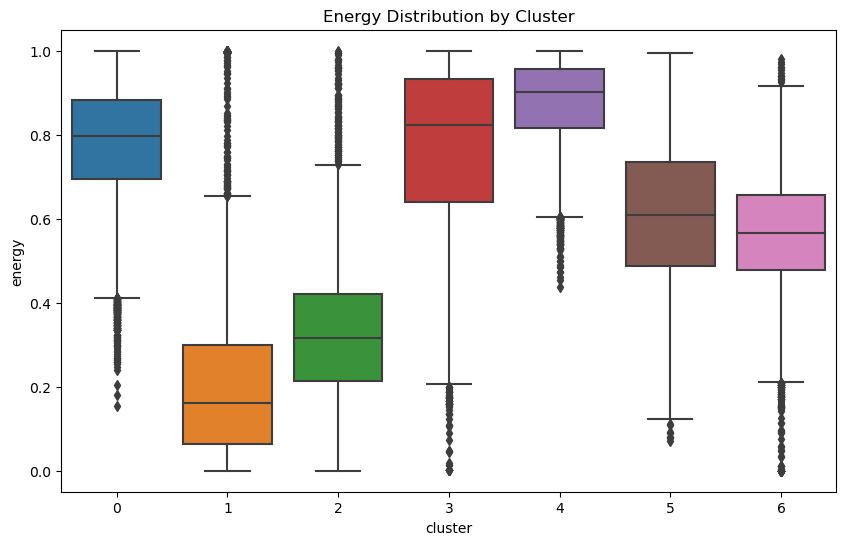

In [78]:
# Box plot of features by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='energy')
plt.title('Energy Distribution by Cluster')
plt.show()


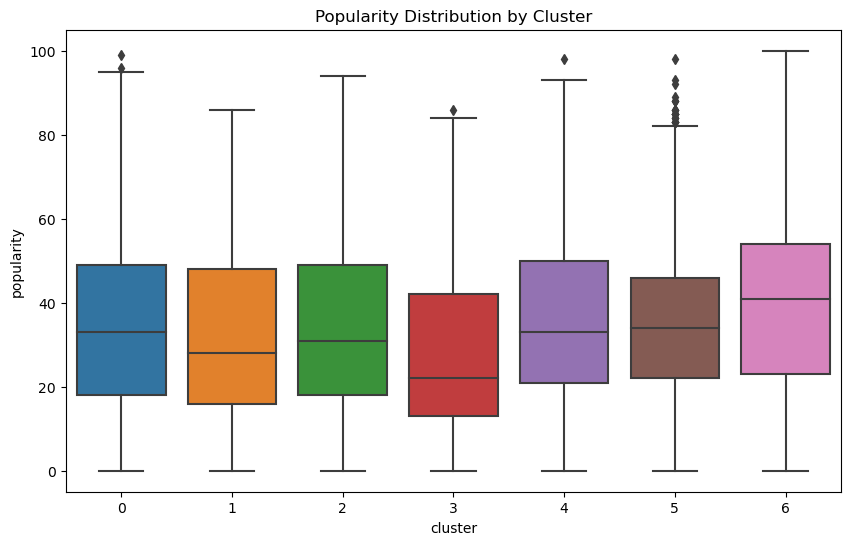

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='popularity')
plt.title('Popularity Distribution by Cluster')
plt.show()

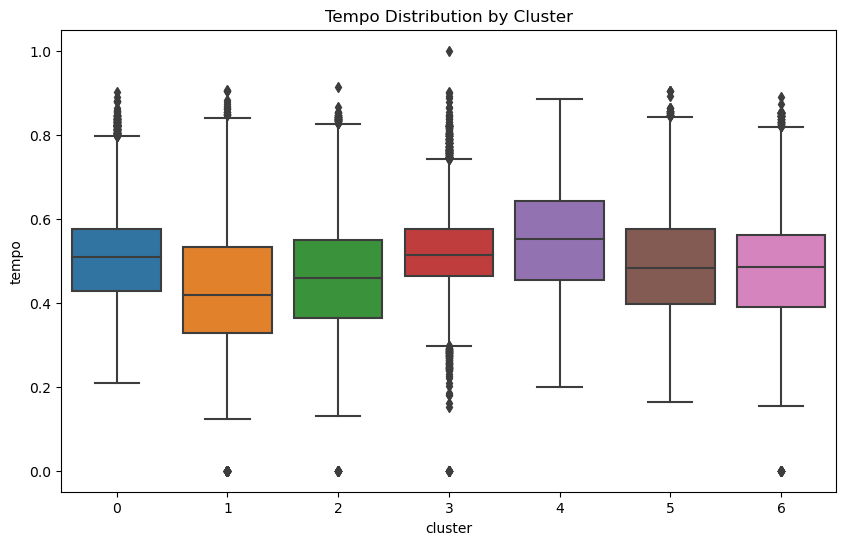

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='tempo')
plt.title('Tempo Distribution by Cluster')
plt.show()

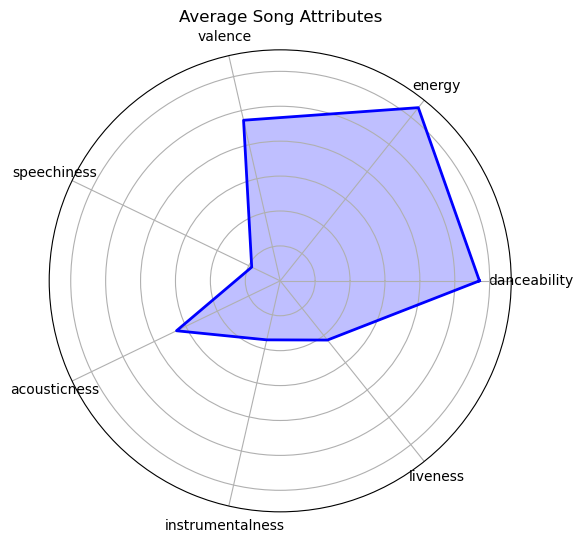

In [81]:
# Select features to plot
attributes = ['danceability', 'energy', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']
df_selected = df[attributes].mean()

# Number of variables we're plotting
num_vars = len(attributes)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# Append the start to the end
df_selected = np.concatenate((df_selected, [df_selected[0]]))
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.fill(angles, df_selected, color='blue', alpha=0.25)
ax.plot(angles, df_selected, color='blue', linewidth=2)

# Labels for each axis
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(attributes)

plt.title('Average Song Attributes')
plt.show()

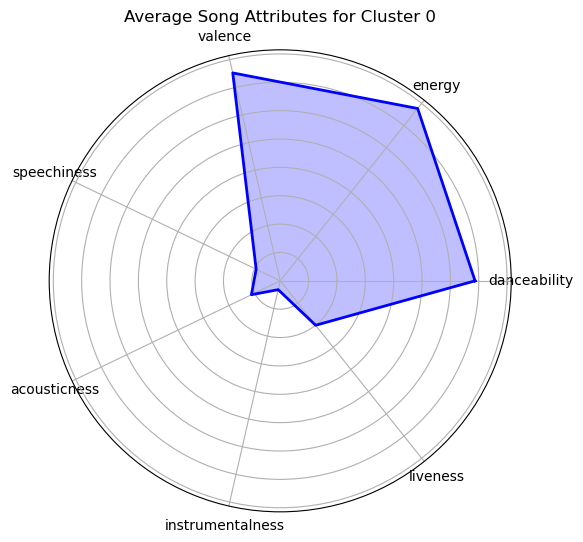

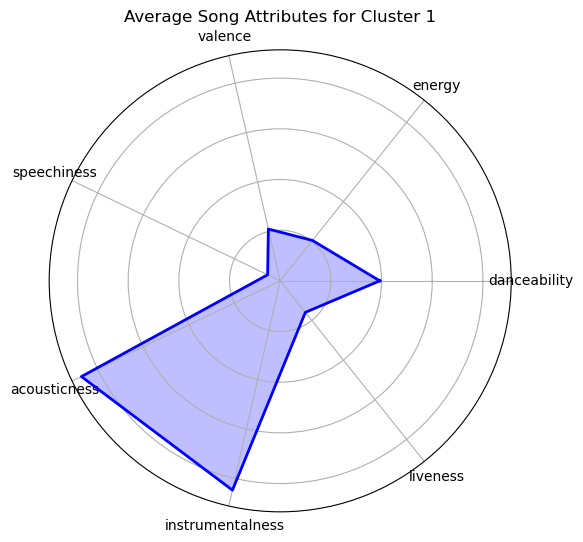

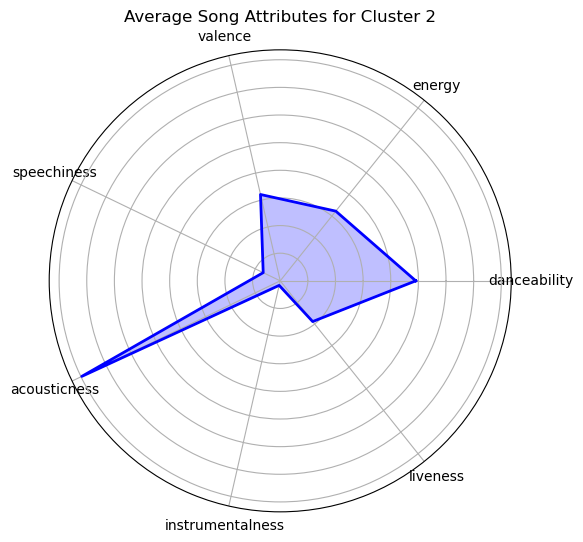

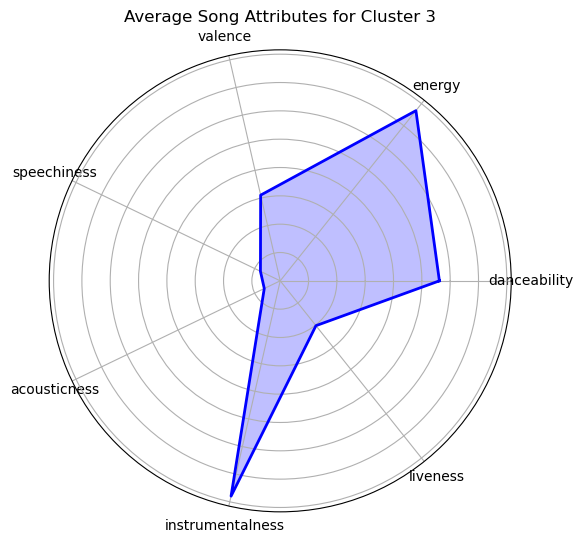

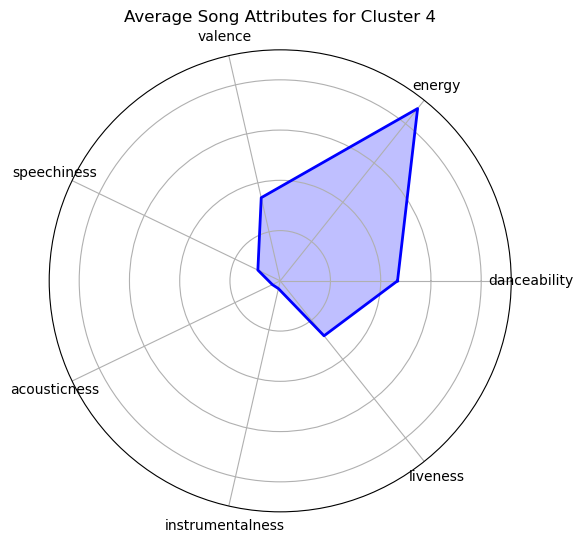

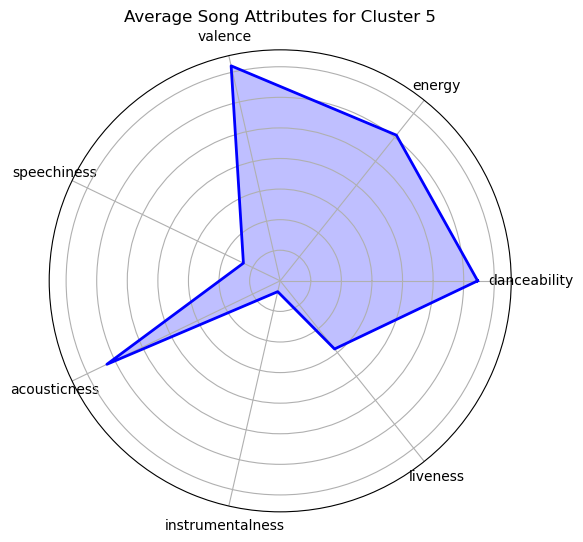

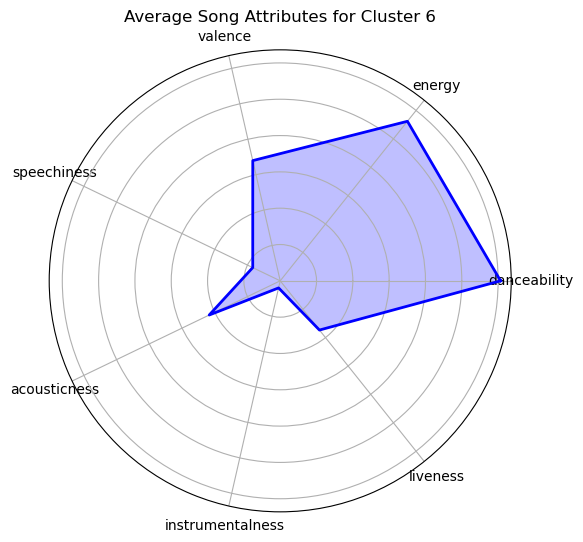

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Define the attributes we're interested in
attributes = ['danceability', 'energy', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']
num_vars = len(attributes)

# Compute the angle for each axis on the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Create radar plots for each cluster
for cluster in sorted(df['cluster'].unique()):
    # Filter data for the current cluster
    df_cluster = df[df['cluster'] == cluster]
    
    # Compute the mean of the attributes for the current cluster
    df_selected = df_cluster[attributes].mean().values
    
    # Complete the loop
    df_selected = np.concatenate((df_selected, [df_selected[0]]))
    angles_with_loop = angles + angles[:1]
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    ax.fill(angles_with_loop, df_selected, color='blue', alpha=0.25)
    ax.plot(angles_with_loop, df_selected, color='blue', linewidth=2)
    
    # Labels for each axis
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(attributes)
    
    # Title for each cluster
    ax.set_title(f'Average Song Attributes for Cluster {cluster}')
    plt.show()
